In [33]:
import datetime
import numpy as np
import pylab as pl
import pandas as pd
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from hmmlearn.hmm import GaussianHMM

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import yfinance as yf

import quantstats as qs
qs.extend_pandas()

import seaborn as sns
sns.set_style('whitegrid')

import dtale

In [58]:
###############################################################################
# Downloading the data
date1 = datetime.date(2016, 1, 1)  # start date
date2 = datetime.date(2022, 2, 8)  # end date
# get quotes from yahoo finance
tickers = 'SPY ^VIX'
quotes = yf.download(tickers, start=date1, end=date2)
if len(quotes) == 0:
    raise SystemExit

[*********************100%***********************]  2 of 2 completed


In [59]:
ticker_df = quotes.loc[:, (slice(None), ["SPY"])].copy()
ticker_df.columns = ticker_df.columns.droplevel(1)
ticker_df.reset_index(inplace=True)
vix_close = quotes[:]['Adj Close']['^VIX']
ticker_df = ticker_df.merge(vix_close.reset_index(), on='Date', how='outer')

In [60]:
ticker_df['pct_change'] = ticker_df['Adj Close'].pct_change()
ticker_df['^VIX'] = ticker_df['^VIX'].shift(21)


#ticker_df['diff'] = ticker_df['Adj Close'].diff()
#ticker_df['5d_pct_change'] = ticker_df['Adj Close'].pct_change(periods=5)
#ticker_df['volume_pct_change'] = ticker_df['Volume'].pct_change()
#ticker_df['std'] = ticker_df['pct_change'].rolling(21).std()

ticker_df.dropna(inplace=True)
ticker_df.set_index('Date', drop=True, inplace=True)

In [61]:
df_test = ticker_df.loc[:,['Open', 'High', 'Low', 'Adj Close', 'Volume', 'pct_change', '^VIX']].copy()

# Train the model on a rolling basis (e.g. using obs from the past [x] years)
(yes I know looping through a DataFrame is inefficient - sorry

In [66]:
obs_cols = ['pct_change', '^VIX']
components = 2
iterations = 10_000
window = 250*1 #business days
total_rows = len(df_test)
ct = 0

df_test['state'] = np.nan

dats = []
transmats = {}

while ct+window <= total_rows:
    df_sub = df_test.iloc[ct:ct+window,:]
    dat = df_sub.iloc[-1:,:].index
    if len(obs_cols) == 1:
        X = np.column_stack([np.array(df_sub[obs_cols[0]])])
    else:
        X = np.array(df_sub[obs_cols[0]])
        for i in np.arange(1,len(obs_cols)):
            X = np.column_stack([X, df_sub[obs_cols[i]]])
    model = GaussianHMM(components, covariance_type="diag", n_iter=iterations)
    model.fit(X)
    # Optimal sequence of internal hidden state
    hidden_states = model.predict(X)
    df_test.loc[df_test.index == dat[0], 'state'] = hidden_states[-1]    
    # Daily transition matrix
    transmats[dat[0]] = model.transmat_[hidden_states[-1]]    
    ct = ct + 1

# (Rough) calculation of total returns under each state

In [67]:
df = df_test.copy()
# Yesterday's hidden state
df['state_plus_1'] = df.state.shift()

df['df'] = df['pct_change']+1
total_rets = {}
for s in np.arange(0, components):
    total_rets[s] = (df[df['state_plus_1'] == s]['df'].cumprod())
df.dropna(inplace=True)
print(f'Number of state changes: {(df.diff(axis=0) != 0).sum(axis=0)[0]}')

Number of state changes: 1262


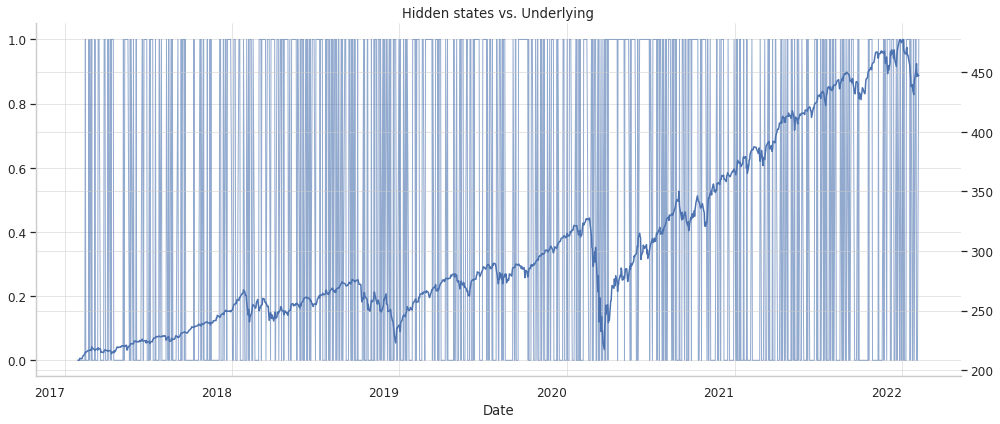

In [68]:
%matplotlib inline
ax1 = df['state_plus_1'].plot(alpha=0.6, title='Hidden states vs. Underlying', figsize=(14,6), lw=1, rot=0)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df['Adj Close'].plot(ax=ax2)
plt.tight_layout()
sns.despine();

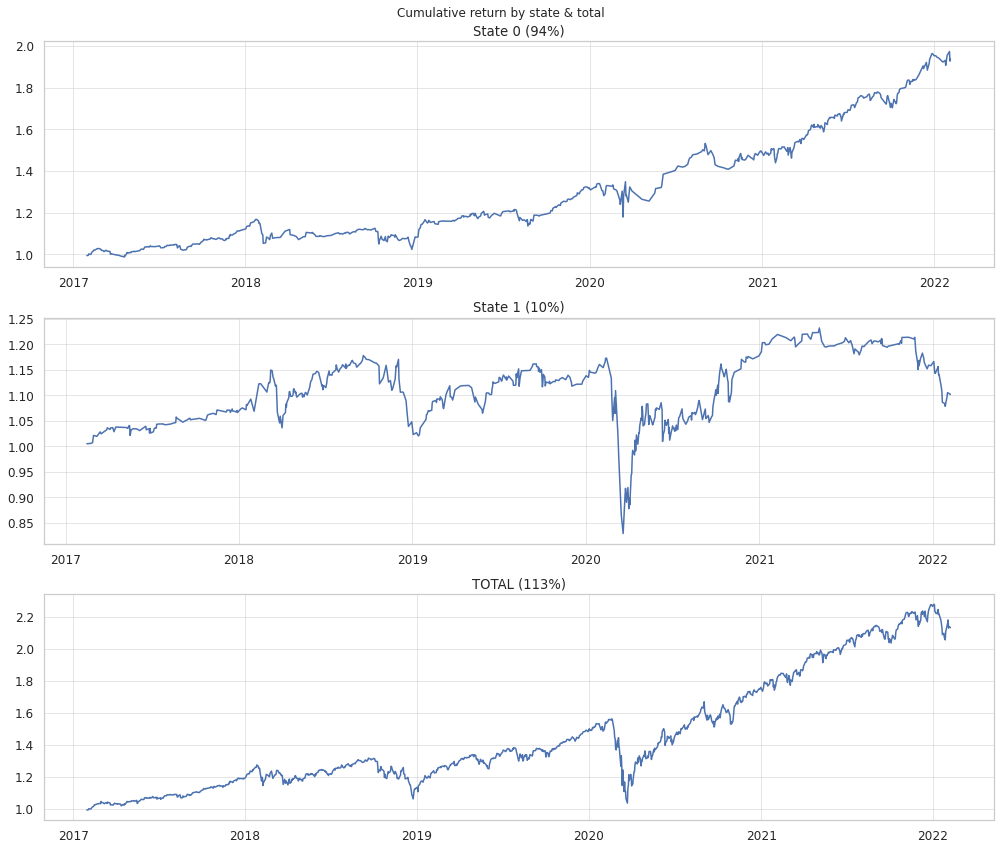

In [69]:
diffB = np.append([0], np.diff(df.state_plus_1))
up = np.where(diffB == 1)[0]
dn = np.where(diffB == -1)[0]
if diffB[np.argmax(diffB!=0)]==-1:
    # we have a falling edge before rising edge, must have started 'up'
    up = np.append([0], up)
if diffB[len(diffB) - np.argmax(diffB[::-1]) - 1]==1:
    # we have a rising edge that never fell, force it 'dn'
    dn = np.append(dn, [len(df.state_plus_1)-1])

fig, axes = plt.subplots(components+1, 1, figsize=(14,12))
for row in range(components):
    ax = axes[row]
    ax.plot(total_rets[row])
    ax.set_title(f'State {row} ({round((total_rets[row][-1]-1)*100)}%)')

ax = axes[components]
ax.plot(df['df'].cumprod())

# for i in range(len(up)):
#     ax.axvspan(df.index[up[i]], df.index[dn[i]], color='r', alpha=0.4, lw=0)
    
tot = df['df'].cumprod()
ax.set_title(f'TOTAL ({round((tot[-1]-1)*100)}%)')

fig.suptitle('Cumulative return by state & total')
fig.tight_layout()
plt.show()

In [73]:
print(np.mean(total_rets[0].pct_change()))
print(np.std(total_rets[0].pct_change())*np.sqrt(252))
print('\n')

print(np.mean(total_rets[1].pct_change()))
print(np.std(total_rets[1].pct_change())*np.sqrt(252))
print('\n')

print(np.mean(tot.pct_change()))
print(np.std(tot.pct_change())*np.sqrt(252))

0.0010198726926901713
0.168621126579996


0.0002514550483892971
0.21253986330248542


0.0006763424083714903
0.18975709602595237
